# Electrode Noise Detection

This notebook will implement a series of first pass machine learning algorithms to test rejection of electrodes.

Noise is categorized for us as the following:
1. EKG vs EEG
2. DC electrodes
3. Reference Electrodes
4. Band noise electrodes -> notch filter
5. General noise electrodes -> reject

Algorithms to systematically explore:
1. Linear Regression
2. Logistic Regression
3. LDA and QDA
4. Naive Bayes
5. KNN
6. SVM
7. LVQ
8. Random Forest
9. Adaboost

Try to do noise vs. no noise electrodes. Then segment further into the different types of noise.

### General List of Features
I will be using raw data windowed, spectral morlet features, and power spectrum. 

### Table of Contents
1. [Importing Data](#section0)


In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from IPython.display import display
import random
random.seed(9001)

# import .mat io
import scipy, scipy.io
try:
    import cPickle as pickle
except:
    import pickle
import time

# import piping and linear models
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# from sklearn.discriminant_analysis.LinearDiscriminantAnalysis import LDA
from sklearn.lda import LDA

# import ensemble techniques
from sklearn.ensemble import RandomForestClassifier

# import feature selection
from sklearn.feature_selection import SelectKBest

# import train/test splitting
from sklearn.model_selection import train_test_split

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

def convertMatToJSON(matData, fileName):
    for key in matData.keys():
        if (type(matData[key])) is np.ndarray:
            serializedData = pickle.dumps(matData[key], protocol=0) # protocol 0 is printable ASCII
            jsonData[key] = serializedData
        else:
            jsonData[key] = matData[key]

    with contextlib.closing(bz2.BZ2File(fileName, 'wb')) as f:
        json.dump(jsonData, f)

# 0. Import Data For Pt1
<a id='section0'></a>

In [3]:
# set root dir
rootDirHome = ''
rootDirWork = '/home/WIN/ali39/Documents/adamli/fragility_dataanalysis/'
if os.path.isdir(rootDirWork):
    rootDir = rootDirWork
elif os.path.isdir(rootDirHome):
    rootDir = rootDirHome
else:
    print "Root directory is not set yet!"

# set center
center = 'nih'
patient = 'pt1sz2'
winSize = '500'
stepSize = '250'
freq = '1000'

parameterDir = 'win' + winSize + '_step' + stepSize + '_freq' + freq
    
# data directories
rawdata_dir = os.path.join(rootDir, 'data', center, patient)
spect_dir = os.path.join(rootDir, 'serverdata', 'spectral_analysis', parameterDir)

In [4]:
# import raw data and separate into their categories
data = loadmat(os.path.join(rawdata_dir, patient + '.mat'))
elec_labels = data['elec_labels']
seiz_start_mark = data['seiz_start_mark']
seiz_end_mark = data['seiz_end_mark']
eegdata = data['data']

In [5]:
# only get preseizure data
eegdata = eegdata[:, 0:seiz_start_mark]

In [6]:
# convert eeg data into a pandas dataframe
eeg = pd.DataFrame(data=eegdata, index=elec_labels).transpose()
display(eeg.head())

,POLG1,POLG2,POLG3,POLG4,POLG5,POLG6,POLG7,POLG8,POLG9,POLG10,...,POLMLT2,POLMLT3,POLMLT4,POLSLT1,POLSLT2,POLSLT3,POLSLT4,POLEKG1,POLEKG2,POL
0,-8.983298,299.221985,244.140961,169.532425,73.048424,-143.355987,248.828827,154.297226,59.378761,-118.750298,...,226.953583,83.594688,310.939362,171.875626,302.351654,198.048309,342.579285,181.263840,225.390213,314.092316
1,8.204192,303.518860,230.078461,161.329300,69.532806,-141.793487,253.516312,155.469101,77.738121,-103.906548,...,247.266067,91.016556,335.548706,185.547501,307.039154,226.954559,371.876160,174.232605,216.015228,371.123383
2,7.422943,296.878235,219.140961,145.704315,64.064064,-135.934128,251.953812,146.094116,80.081863,-96.094048,...,255.859817,91.407181,339.454956,186.719360,306.648529,235.157684,388.673035,156.263885,191.405853,391.826446
3,-9.764548,283.987640,202.344086,129.688690,59.376572,-128.512268,239.063202,143.359741,75.784996,-99.219048,...,257.422333,90.625931,345.314331,187.109985,292.586029,236.329559,403.516785,207.435669,223.437088,395.732696
4,-40.233284,268.753265,197.265976,108.594955,55.860951,-122.262276,239.453827,143.750366,63.285007,-105.859673,...,257.812958,75.000938,341.798706,186.328735,269.539185,216.407684,400.391785,271.888702,258.202698,327.764130


In [7]:
# label certain electrodes as noise
noise_channels = np.arange(37,42) - 1
noise_channels = np.append(noise_channels, np.array((44, 45, 55, 61, 70, 71, 96, 97, 98))-1)
other_channels = np.arange(0, len(elec_labels))
other_channels = np.delete(other_channels, noise_channels)

correct_labels = elec_labels[other_channels]
noise_labels = elec_labels[noise_channels]

print len(other_channels)
print len(noise_channels)

print "Coin toss positive: ", float(len(noise_channels))/len(elec_labels)
print "Coin toss negative: ", len(other_channels)/float(len(elec_labels))

84
14
Coin toss positive:  0.142857142857
Coin toss negative:  0.857142857143


In [8]:
# add labels dataframe
labelsdf = pd.DataFrame(eeg.columns.values)
labels = np.copy(eeg.columns.values)
labels[noise_channels] = 1
labels[other_channels] = 0

# create a labels data frame
labelsdf = pd.concat([labelsdf, pd.DataFrame(labels)], axis=1)
labelsdf.columns = ['Chans', 'Noise Labels']
display(labelsdf.head())

,Chans,Noise Labels
0,POLG1,0
1,POLG2,0
2,POLG3,0
3,POLG4,0
4,POLG5,0


# 1. Apply Linear Regression
<a id='section1'></a>

# 2. Logistic Regression
<a id='section2'></a>

In [9]:
print labelsdf.shape
print eegdata.shape


(98, 2)
(98, 85000)


In [14]:
# split into cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(eegdata, labelsdf['Noise Labels'], test_size=0.3, random_state=0)

# initialize logistic model
logistic = linear_model.LogisticRegression()

# initialize pca
pca = decomposition.PCA()
start = time.clock()

pca.fit(eegdata)

elapsed = time.clock()
elapsed = elapsed - start
print "Time spent in PCA is: ", elapsed, ' seconds'

Time spent in PCA is:  16.481527  seconds


(98, 85000)


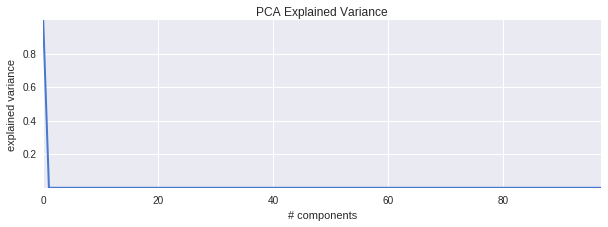

In [11]:
print eegdata.shape

plt.figure(1, figsize=(10,3))
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.title('PCA Explained Variance')
plt.xlabel('# components')
plt.ylabel('explained variance')

In [15]:
# paramters for logistic reg in pipeline
Cs = np.logspace(-4, 4, 5)
penalty = ['l1', 'l2']

# create a pipe
steps = [('logistic', logistic)]
pipe = Pipeline(steps=steps)

# create grid search estimator
parameters = dict(
    logistic__C = Cs,
    logistic__penalty = penalty
)

estimator = GridSearchCV(pipe, param_grid=parameters)

In [ ]:
# fit estimator and log time spent
start = time.clock()

estimator.fit(X_train, list(y_train))
y_predict = estimator.predict(X_test)

elapsed = time.clock()
elapsed = elapsed - start

report = sklearn.metrics.classification_report(y_test, y_predict)

print "Time spent in Logistic Regression Grid Search is: ", elapsed
print report
print estimator.best_params_